# **CAPSTONE PROJECT 2**
### [Fraud Detection]

**Student Name:** Ben Duong 
**Date:** 20/01/2026 
**Course:** Intermediate AI & Data Science  
**Instructor:** Amir Charkhi  
**AI Tech Institute**

---

## 📋 Project Overview

**Problem:** Financial institutions and online platforms face significant challenges in detecting fraudulent transactions in real time. Fraudulent activity not only results in monetary losses but also erodes customer trust and damages brand reputation. The goal of this project is to build a machine learning model that can accurately predict whether a transaction is fraudulent.

**Business Value:** Effective fraud detection reduces financial losses, safeguards customers, and strengthens institutional credibility

**Data Source:** Kaggle. IEEE-CID Fraud detection

**Target Variable:** isFraud (binary classification: 1 = fraudulent transaction, 0 = legitimate transaction)

**Success Metric:** Recall (Sensitivity): High recall ensures that most fraudulent transactions are correctly identified.

F1 Score: Balances precision and recall, providing a robust measure of overall model performance.

AUC-ROC: Evaluates the model’s ability to distinguish between fraud and non-fraud cases.

---

## 1. Setup & Imports

In [1]:
pip install xgboost

Note: you may need to restart the kernel to use updated packages.


In [2]:
# Standard imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

# Set random seed for reproducibility
np.random.seed(42)

In [3]:
# Plotly for interactive visualizations
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots

In [4]:
# Scikit-learn imports
from sklearn.model_selection import train_test_split, cross_val_score, RandomizedSearchCV, StratifiedKFold
from sklearn.preprocessing import StandardScaler, LabelEncoder,OneHotEncoder, TargetEncoder
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.decomposition import PCA

from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression,LinearRegression
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from xgboost import XGBClassifier

# etc.

In [67]:
# Metrics (adjust based on your problem type)
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,  # Classification
    classification_report, confusion_matrix    , roc_curve,auc                # Detailed reports
)

In [6]:
# Model persistence
import joblib

---
## 2. Load Data

In [7]:
trans_train = pd.read_csv('train_transaction.csv')
identity_train = pd.read_csv('train_identity.csv')

In [8]:
print(trans_train.head(10))

print("="*90)

print(identity_train.head(10))

   TransactionID  isFraud  TransactionDT  TransactionAmt ProductCD  card1  \
0        2987000        0          86400            68.5         W  13926   
1        2987001        0          86401            29.0         W   2755   
2        2987002        0          86469            59.0         W   4663   
3        2987003        0          86499            50.0         W  18132   
4        2987004        0          86506            50.0         H   4497   
5        2987005        0          86510            49.0         W   5937   
6        2987006        0          86522           159.0         W  12308   
7        2987007        0          86529           422.5         W  12695   
8        2987008        0          86535            15.0         H   2803   
9        2987009        0          86536           117.0         W  17399   

   card2  card3       card4  card5  ... V330  V331  V332  V333  V334 V335  \
0    NaN  150.0    discover  142.0  ...  NaN   NaN   NaN   NaN   NaN  NaN  

### Data Optimization

 The dataset contains approximately 594,000 rows and more than 400 columns, which can exceed the storage and memory capacity of a local machine. To improve efficiency and reduce resource usage, a function was applied to adjust the data types of all columns, ensuring optimal memory utilization without compromising data integrity (This function was taken from a Kaggle notebook.).



In [9]:
# Helper function
def reduce_mem_usage(df):
    """ iterate through all the columns of a dataframe and modify the data type
        to reduce memory usage.        
    """
    start_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage of dataframe is {:.2f} MB'.format(start_mem))
    
    for col in df.columns:
        col_type = df[col].dtype
        
        if col_type != object:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)
        else:
            df[col] = df[col].astype('category')

    end_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage after optimization is: {:.2f} MB'.format(end_mem))
    print('Decreased by {:.1f}%'.format(100 * (start_mem - end_mem) / start_mem))
    
    return df

In [10]:
trans_train_reduced = reduce_mem_usage(trans_train) 

Memory usage of dataframe is 1775.15 MB
Memory usage after optimization is: 487.16 MB
Decreased by 72.6%


In [11]:
## Merging transaction and identity data

trans_train_merged = pd.merge(trans_train_reduced, identity_train, on='TransactionID', how='left')




In [12]:
# Dataset shape
print(f"Train Dataset: {trans_train_merged.shape[0]} rows × {trans_train_merged.shape[1]} columns.\n")
    
print(trans_train_merged.head(10))


Train Dataset: 590540 rows × 434 columns.

   TransactionID  isFraud  TransactionDT  TransactionAmt ProductCD  card1  \
0        2987000        0          86400            68.5         W  13926   
1        2987001        0          86401            29.0         W   2755   
2        2987002        0          86469            59.0         W   4663   
3        2987003        0          86499            50.0         W  18132   
4        2987004        0          86506            50.0         H   4497   
5        2987005        0          86510            49.0         W   5937   
6        2987006        0          86522           159.0         W  12308   
7        2987007        0          86529           422.5         W  12695   
8        2987008        0          86535            15.0         H   2803   
9        2987009        0          86536           117.0         W  17399   

   card2  card3       card4  card5  ...                id_31  id_32  \
0    NaN  150.0    discover  142.0  ..

---
## 3. Exploratory Data Analysis (EDA)

### 3.1 Basic Statistics

In [13]:
trans_train_merged.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 590540 entries, 0 to 590539
Columns: 434 entries, TransactionID to DeviceInfo
dtypes: category(14), float16(332), float32(44), float64(23), int16(1), int32(2), int8(1), object(17)
memory usage: 667.4+ MB


In [14]:
trans_train_merged

,TransactionID,isFraud,TransactionDT,TransactionAmt,ProductCD,card1,card2,card3,card4,card5,...,id_31,id_32,id_33,id_34,id_35,id_36,id_37,id_38,DeviceType,DeviceInfo
0,2987000,0,86400,68.500000,W,13926,NaN,150.0,discover,142.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2987001,0,86401,29.000000,W,2755,404.0,150.0,mastercard,102.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2987002,0,86469,59.000000,W,4663,490.0,150.0,visa,166.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2987003,0,86499,50.000000,W,18132,567.0,150.0,mastercard,117.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2987004,0,86506,50.000000,H,4497,514.0,150.0,mastercard,102.0,...,samsung browser 6.2,32.0,2220x1080,match_status:2,T,F,T,T,mobile,SAMSUNG SM-G892A Build/NRD90M
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
590535,3577535,0,15811047,49.000000,W,6550,NaN,150.0,visa,226.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
590536,3577536,0,15811049,39.500000,W,10444,225.0,150.0,mastercard,224.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
590537,3577537,0,15811079,30.953125,W,12037,595.0,150.0,mastercard,224.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
590538,3577538,0,15811088,117.000000,W,7826,481.0,150.0,mastercard,224.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [15]:
# Check missing values
missing = trans_train_merged.isnull().mean()
missing =  missing[missing > 0].reset_index()
missing.rename(columns={0: 'missing_percentage'}, inplace=True)
missing.sort_values(by='missing_percentage', ascending=False).head(20)



,index,missing_percentage
397,id_24,0.991962
398,id_25,0.991310
380,id_07,0.991271
381,id_08,0.991271
394,id_21,0.991264
399,id_26,0.991257
400,id_27,0.991247
396,id_23,0.991247
395,id_22,0.991247
8,dist2,0.936284


### 3.2 Target Variable Analysis

In [16]:
trans_train_merged.iloc[:, :15]

,TransactionID,isFraud,TransactionDT,TransactionAmt,ProductCD,card1,card2,card3,card4,card5,card6,addr1,addr2,dist1,dist2
0,2987000,0,86400,68.500000,W,13926,NaN,150.0,discover,142.0,credit,315.0,87.0,19.0,NaN
1,2987001,0,86401,29.000000,W,2755,404.0,150.0,mastercard,102.0,credit,325.0,87.0,NaN,NaN
2,2987002,0,86469,59.000000,W,4663,490.0,150.0,visa,166.0,debit,330.0,87.0,287.0,NaN
3,2987003,0,86499,50.000000,W,18132,567.0,150.0,mastercard,117.0,debit,476.0,87.0,NaN,NaN
4,2987004,0,86506,50.000000,H,4497,514.0,150.0,mastercard,102.0,credit,420.0,87.0,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
590535,3577535,0,15811047,49.000000,W,6550,NaN,150.0,visa,226.0,debit,272.0,87.0,48.0,NaN
590536,3577536,0,15811049,39.500000,W,10444,225.0,150.0,mastercard,224.0,debit,204.0,87.0,NaN,NaN
590537,3577537,0,15811079,30.953125,W,12037,595.0,150.0,mastercard,224.0,debit,231.0,87.0,NaN,NaN
590538,3577538,0,15811088,117.000000,W,7826,481.0,150.0,mastercard,224.0,debit,387.0,87.0,3.0,NaN


In [17]:
trans_train_merged["isFraud"].value_counts(normalize=True)

isFraud
0    0.96501
1    0.03499
Name: proportion, dtype: float64

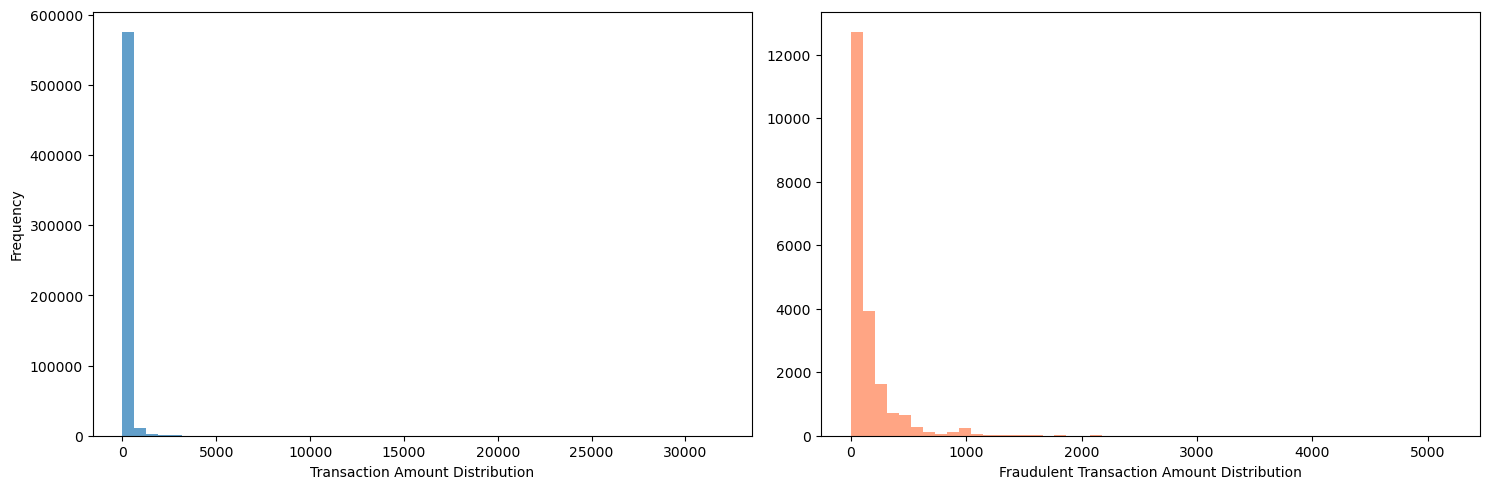


Transaction Amount Statistics Comparison
                       Type       Mean  Median  Standard Deviation
           All Transactions 135.027347   68.75          239.157438
    Fraudulent Transactions 149.244353   75.00          232.208745
Non-Fraudulent Transactions 134.511857   68.50          239.389936


In [18]:
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

ax1 =axes[0]
ax1.hist(trans_train_merged['TransactionAmt'], bins=50, alpha=0.7)
ax1.set_xlabel('Transaction Amount Distribution')
ax1.set_ylabel('Frequency')

ax2 =axes[1]
ax2.hist(trans_train_merged[trans_train_merged['isFraud']==1]['TransactionAmt'], bins=50,color='coral', alpha=0.7)
ax2.set_xlabel('Fraudulent Transaction Amount Distribution')


plt.tight_layout()
plt.show()


fraud_amt = trans_train_merged[trans_train_merged['isFraud']==1]['TransactionAmt'].astype(float)
non_fraud_amt = trans_train_merged[trans_train_merged['isFraud']==0]['TransactionAmt'].astype(float)
total_amt = trans_train_merged['TransactionAmt'].astype(float)

# Create comparison table
comparison_df = pd.DataFrame({
    'Type': [
        'All Transactions',
        'Fraudulent Transactions',
        'Non-Fraudulent Transactions'
     
    ],
    'Mean': [
        total_amt.mean(),
        fraud_amt.mean(),
        non_fraud_amt.mean()
    ],
    'Median': [
        total_amt.median(),
        fraud_amt.median(),
        non_fraud_amt.median()
    ],
    'Standard Deviation': [
        total_amt.std(),
        fraud_amt.std(),    
        non_fraud_amt.std()
    ]
})



print("\n" + "="*90)
print("Transaction Amount Statistics Comparison")
print("="*90)
print(comparison_df.to_string(index=False))




### 3.3 Feature Distributions

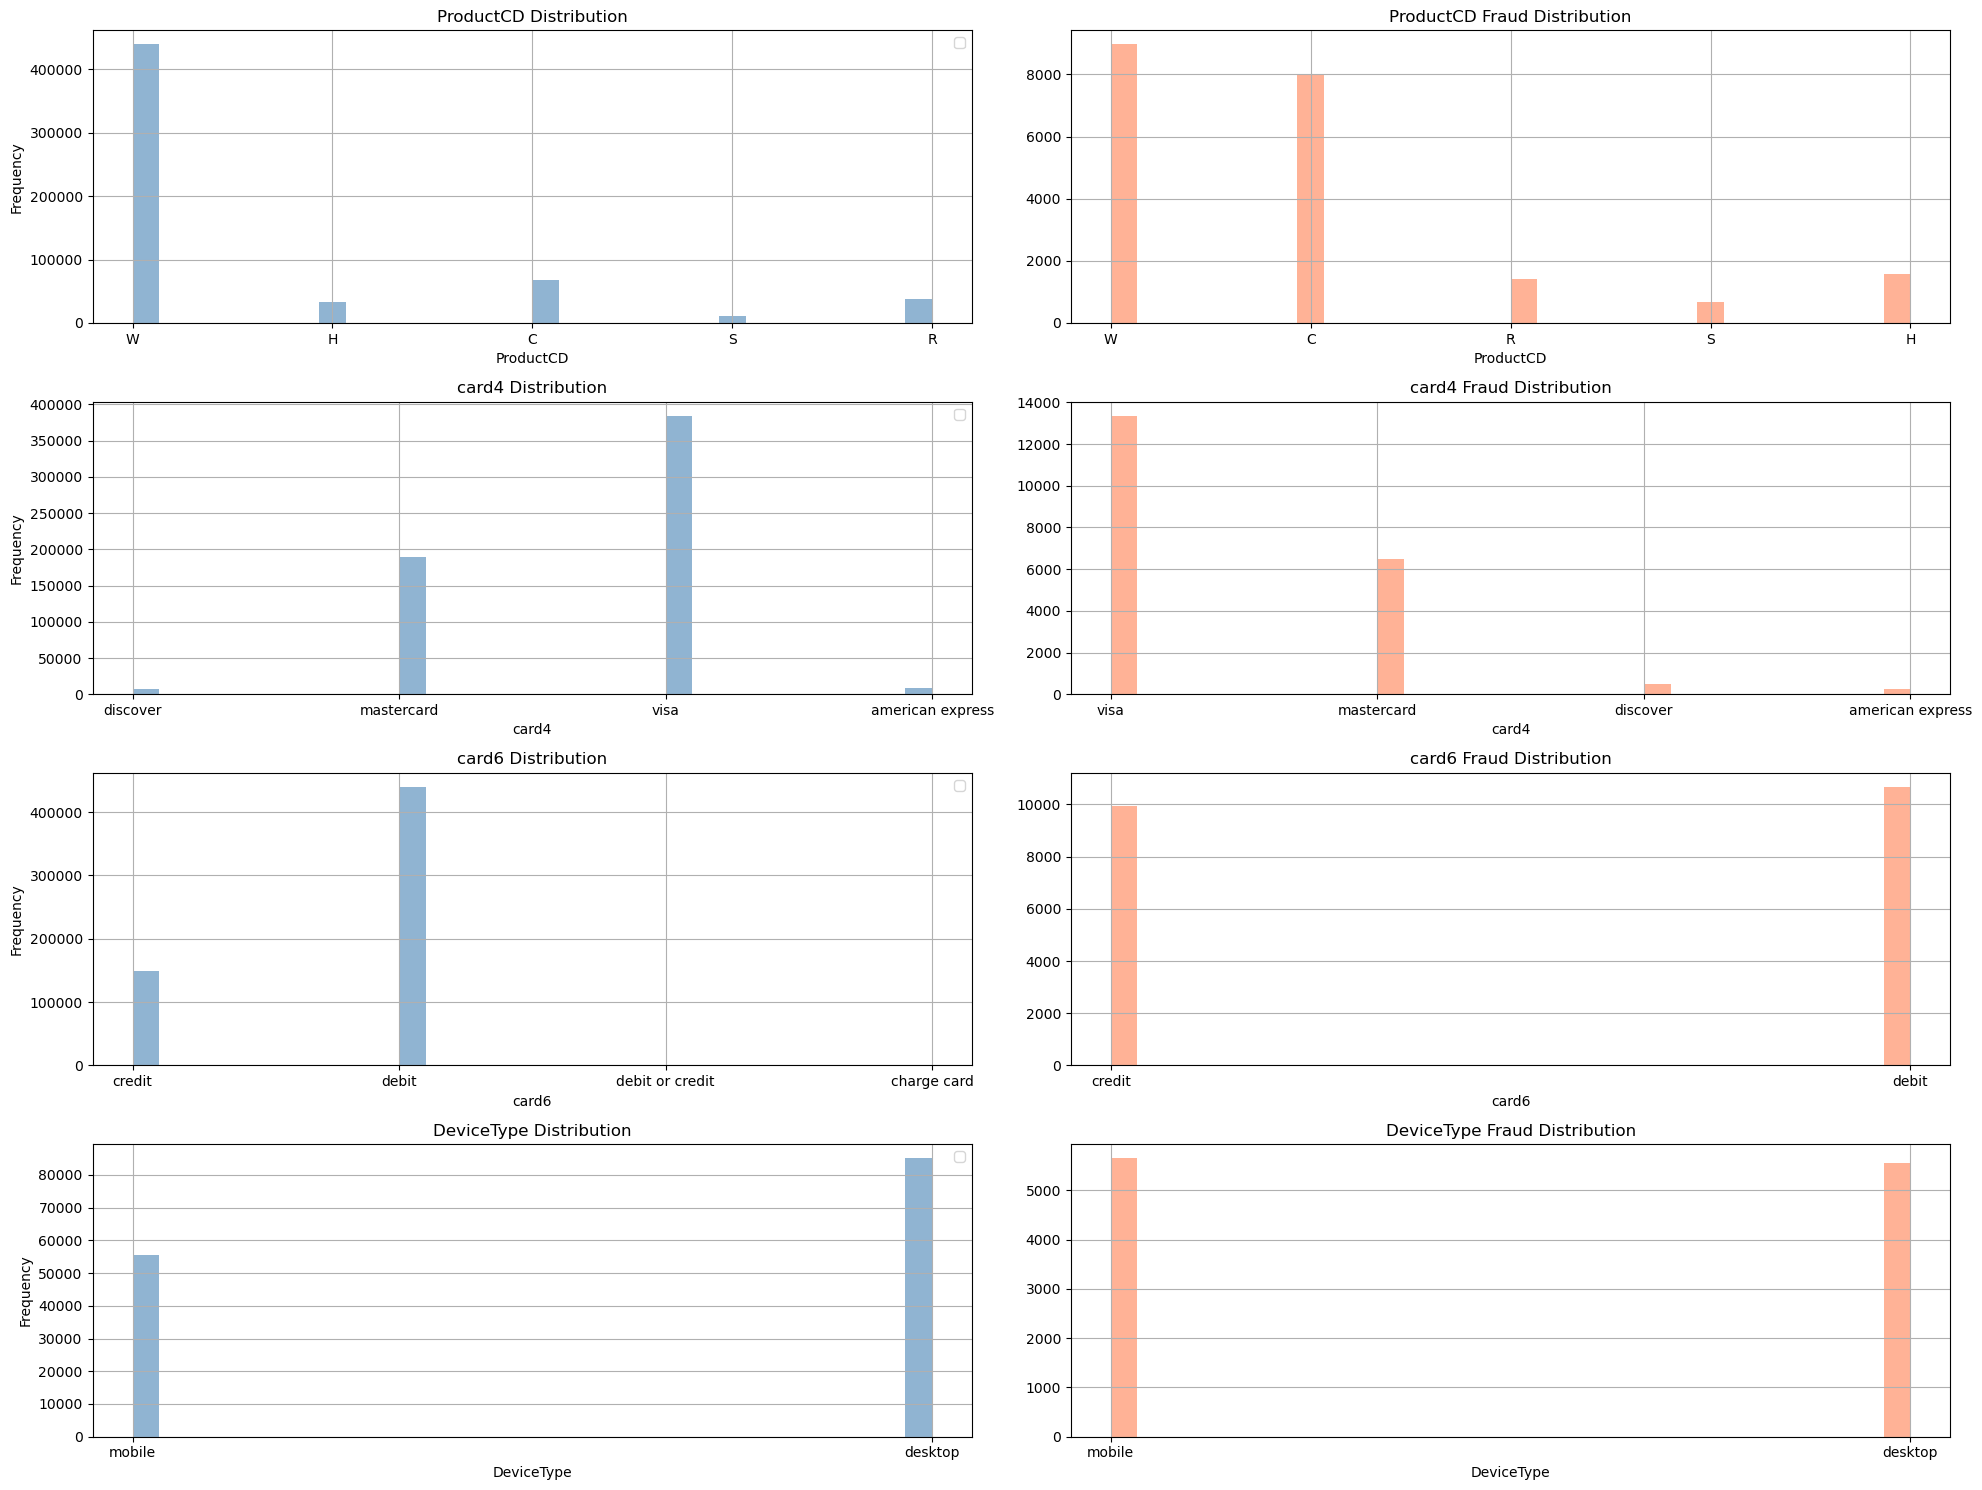

In [19]:
# Visualize key features by class
key_features = ['ProductCD', 'card4', 'card6', 'DeviceType']
fig, axes = plt.subplots(4, 2, figsize=(20, 15))
axes = axes.ravel()
n = 0

for idx, feature in enumerate(key_features):
    if idx > 0:
        idx = idx + n

    trans_train_merged[feature].hist(bins=30, alpha=0.6,   ax=axes[idx], color='steelblue')
 
    axes[idx].set_xlabel(feature)
    axes[idx].set_ylabel('Frequency')
    axes[idx].legend()
    axes[idx].set_title(f'{feature} Distribution')

    idx = idx + 1

    trans_train_merged[trans_train_merged['isFraud']==1][feature].hist(bins=30, alpha=0.6
                                                      , ax=axes[idx], color='coral')
    axes[idx].set_xlabel(feature)
    axes[idx].set_title(f'{feature} Fraud Distribution')

    n+=1



plt.tight_layout()
plt.show()

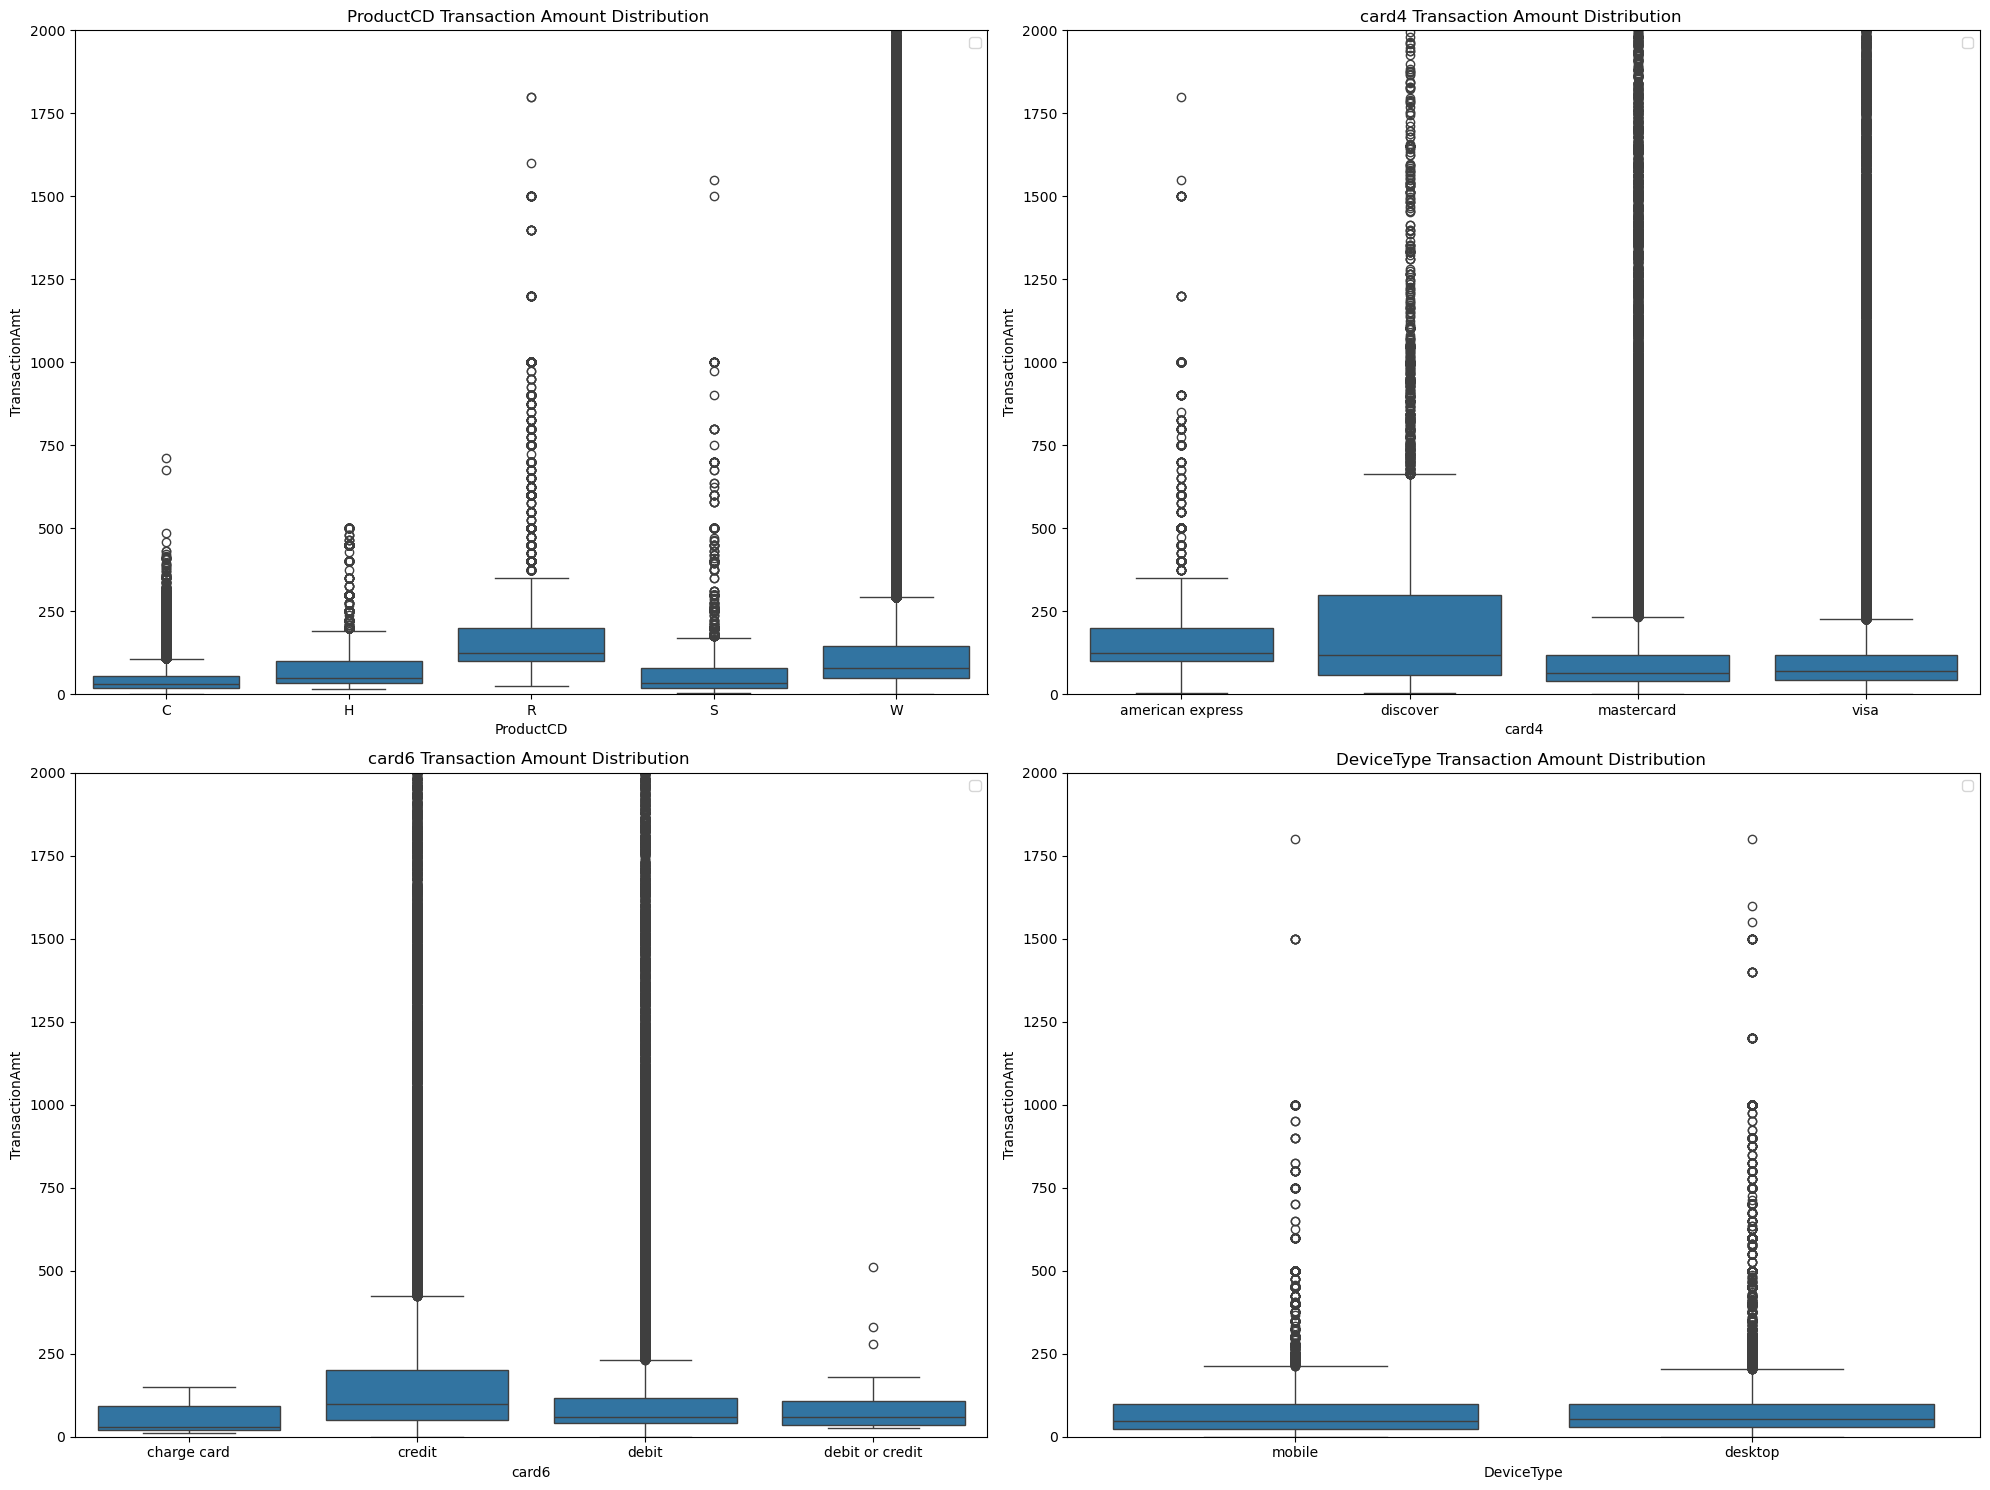

In [20]:
# Visualize key features by class

key_features = ['ProductCD', 'card4', 'card6', 'DeviceType']
fig, axes = plt.subplots(2, 2, figsize=(20, 15))
axes = axes.ravel()

for idx, feature in enumerate(key_features):

    sns.boxplot(data=trans_train_merged, x=feature,y= trans_train_merged["TransactionAmt"], ax=axes[idx])

    axes[idx].legend()
    axes[idx].set_title(f'{feature} Transaction Amount Distribution ')
    axes[idx].set_ylim(0, 2000) #Remove outliers


plt.tight_layout()
plt.show()

     C1   C2   C3   C4   C5   C6   C7   C8   C9  C10  C11  C12   C13  C14
0   1.0  1.0  0.0  0.0  0.0  1.0  0.0  0.0  1.0  0.0  2.0  0.0   1.0  1.0
1   1.0  1.0  0.0  0.0  0.0  1.0  0.0  0.0  0.0  0.0  1.0  0.0   1.0  1.0
2   1.0  1.0  0.0  0.0  0.0  1.0  0.0  0.0  1.0  0.0  1.0  0.0   1.0  1.0
3   2.0  5.0  0.0  0.0  0.0  4.0  0.0  0.0  1.0  0.0  1.0  0.0  25.0  1.0
4   1.0  1.0  0.0  0.0  0.0  1.0  0.0  1.0  0.0  1.0  1.0  0.0   1.0  1.0
5   1.0  1.0  0.0  0.0  0.0  1.0  0.0  0.0  1.0  0.0  1.0  0.0   1.0  1.0
6   1.0  1.0  0.0  0.0  0.0  1.0  0.0  0.0  1.0  0.0  1.0  0.0   1.0  1.0
7   1.0  1.0  0.0  0.0  0.0  1.0  0.0  0.0  0.0  0.0  1.0  0.0   1.0  1.0
8   1.0  1.0  0.0  0.0  0.0  1.0  0.0  1.0  0.0  1.0  1.0  0.0   1.0  1.0
9   2.0  2.0  0.0  0.0  0.0  3.0  0.0  0.0  3.0  0.0  1.0  0.0  12.0  2.0
10  1.0  4.0  0.0  1.0  0.0  1.0  1.0  1.0  0.0  1.0  2.0  2.0   2.0  1.0
11  1.0  1.0  0.0  1.0  0.0  1.0  1.0  1.0  0.0  1.0  1.0  1.0   1.0  1.0
12  4.0  2.0  0.0  0.0  0.0  1.0  0.0 

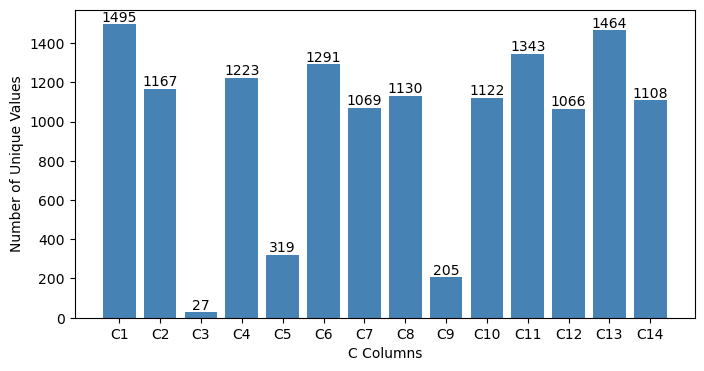

In [21]:
#First Encoded column set

c_columns = trans_train_merged.filter(regex='C\d').columns.tolist()

plt.figure(figsize=(8, 4))
for col in c_columns:
    ax = plt.bar(col, trans_train_merged[col].nunique(), color='steelblue')
    plt.bar_label(ax)
plt.xlabel('C Columns')
plt.ylabel('Number of Unique Values')

print(trans_train_merged.filter(regex='C\d').head(20))

       D1     D2    D3     D4    D5   D6   D7    D8   D9    D10    D11  D12  \
0    14.0    NaN  13.0    NaN   NaN  NaN  NaN   NaN  NaN   13.0   13.0  NaN   
1     0.0    NaN   NaN    0.0   NaN  NaN  NaN   NaN  NaN    0.0    NaN  NaN   
2     0.0    NaN   NaN    0.0   NaN  NaN  NaN   NaN  NaN    0.0  315.0  NaN   
3   112.0  112.0   0.0   94.0   0.0  NaN  NaN   NaN  NaN   84.0    NaN  NaN   
4     0.0    NaN   NaN    NaN   NaN  NaN  NaN   NaN  NaN    NaN    NaN  NaN   
5     0.0    NaN   NaN    0.0   NaN  NaN  NaN   NaN  NaN    0.0    0.0  NaN   
6     0.0    NaN   NaN    0.0   NaN  NaN  NaN   NaN  NaN    0.0    0.0  NaN   
7     0.0    NaN   NaN    0.0   NaN  NaN  NaN   NaN  NaN    0.0    NaN  NaN   
8     0.0    NaN   NaN    NaN   NaN  NaN  NaN   NaN  NaN    NaN    NaN  NaN   
9    61.0   61.0  30.0  318.0  30.0  NaN  NaN   NaN  NaN   40.0  302.0  NaN   
10    1.0    1.0   0.0    0.0   0.0  0.0  0.0  83.0  0.0    0.0    NaN  0.0   
11    0.0    NaN   NaN    0.0   NaN  0.0  NaN   NaN 

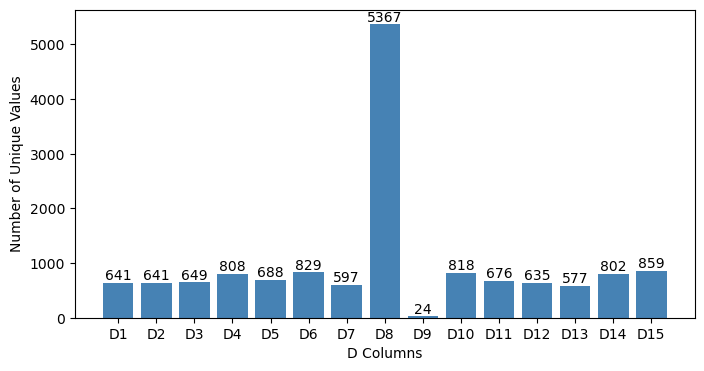

In [22]:
#Second Encoded column set

d_columns = trans_train_merged.filter(regex='D\d').columns.tolist()

plt.figure(figsize=(8, 4))
for col in d_columns:
    ax = plt.bar(col, trans_train_merged[col].nunique(), color='steelblue')
    plt.bar_label(ax)
plt.xlabel('D Columns')
plt.ylabel('Number of Unique Values')

print(trans_train_merged.filter(regex='D\d').head(20))

     M1   M2   M3   M4   M5   M6   M7   M8   M9
0     T    T    T   M2    F    T  NaN  NaN  NaN
1   NaN  NaN  NaN   M0    T    T  NaN  NaN  NaN
2     T    T    T   M0    F    F    F    F    F
3   NaN  NaN  NaN   M0    T    F  NaN  NaN  NaN
4   NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN
5     T    T    T   M1    F    T  NaN  NaN  NaN
6     T    T    T   M0    F    F    T    T    T
7   NaN  NaN  NaN   M0    F    F  NaN  NaN  NaN
8   NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN
9     T    T    T   M0    T    T  NaN  NaN  NaN
10  NaN  NaN  NaN   M0  NaN  NaN  NaN  NaN  NaN
11  NaN  NaN  NaN   M0  NaN  NaN  NaN  NaN  NaN
12  NaN  NaN  NaN   M1    F    F  NaN  NaN  NaN
13  NaN  NaN  NaN  NaN  NaN    F  NaN  NaN  NaN
14  NaN  NaN  NaN   M0    F    F  NaN  NaN  NaN
15    T    T    F  NaN  NaN    F    F    F    T
16  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN
17  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN
18    T    T    F  NaN  NaN    F    F    T    T
19  NaN  NaN  NaN   M1    F    F  NaN  N

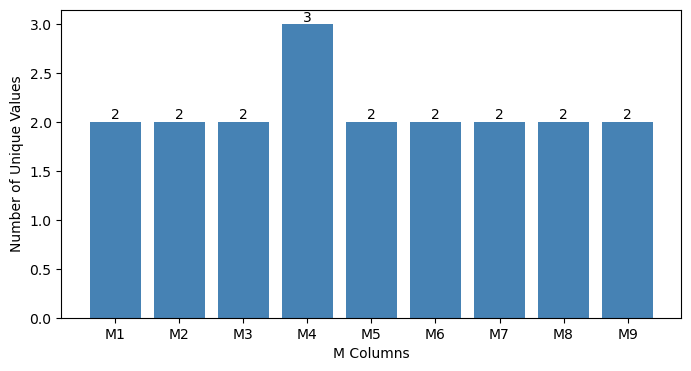

In [23]:
#Third Encoded column set

m_columns = trans_train_merged.filter(regex='M\d').columns.tolist()

plt.figure(figsize=(8, 4))
for col in m_columns:
    ax = plt.bar(col, trans_train_merged[col].nunique(), color='steelblue')
    plt.bar_label(ax)
plt.xlabel('M Columns')
plt.ylabel('Number of Unique Values')


print(trans_train_merged.filter(regex='M\d').head(20))

In [24]:
v_columns = trans_train_merged.filter(regex='V\d').columns.tolist()
v_unique_counts = trans_train_merged[v_columns].nunique()

top20 = v_unique_counts.sort_values(ascending=False).head(10)

Number of V columns: 339
           V307    V127        V308        V306    V317        V203   V128  \
0    117.000000   117.0    0.000000    0.000000   117.0         NaN    0.0   
1      0.000000     0.0    0.000000    0.000000     0.0         NaN    0.0   
2      0.000000     0.0    0.000000    0.000000     0.0         NaN    0.0   
3   1758.000000  1758.0  925.000000   50.000000  1404.0         NaN  925.0   
4      0.000000     0.0    0.000000    0.000000     0.0    0.000000    0.0   
5      0.000000     0.0    0.000000    0.000000     0.0         NaN    0.0   
6      0.000000     0.0    0.000000    0.000000     0.0         NaN    0.0   
7      0.000000     0.0    0.000000    0.000000     0.0         NaN    0.0   
8      0.000000     0.0    0.000000    0.000000     0.0    0.000000    0.0   
9      0.000000     0.0    0.000000    0.000000     0.0         NaN    0.0   
10   166.215393     0.0  166.215393  166.215393     0.0  166.215393    0.0   
11     0.000000     0.0    0.000000    

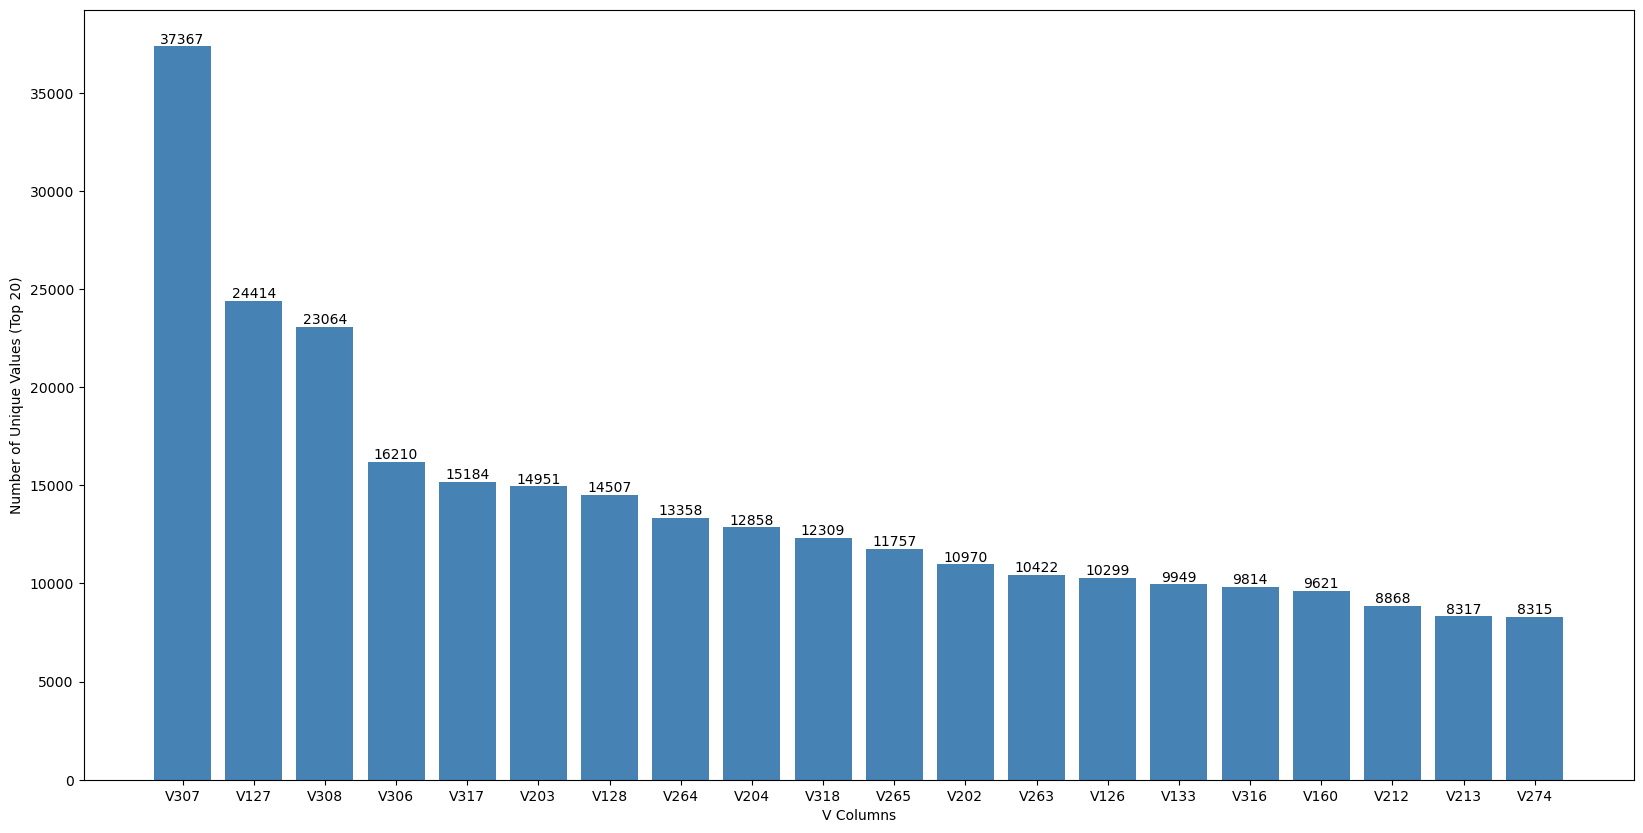

In [25]:
#Third Encoded column set

v_columns = trans_train_merged.filter(regex='V\d').columns.tolist()

print(f"Number of V columns: {len(v_columns)}")

v_unique_counts = trans_train_merged[v_columns].nunique()
top20 = v_unique_counts.sort_values(ascending=False).head(20)

plt.figure(figsize=(20, 10))
for col in top20.index:
    ax = plt.bar(col, top20[col]   , color='steelblue')
    plt.bar_label(ax)
plt.xlabel('V Columns')
plt.ylabel('Number of Unique Values (Top 20)')

print(trans_train_merged[top20.index].head(20))

### 3.4 Correlations

In [26]:
# Correlation matrix

top_10_corr = trans_train_merged.corr(numeric_only=True)["isFraud"].abs().sort_values(ascending=False).head(11)


top_10_corr



isFraud    1.000000
V257       0.383060
V246       0.366878
V244       0.364129
V242       0.360590
V201       0.328005
V200       0.318783
V189       0.308219
V188       0.303582
V258       0.297151
V45        0.281832
Name: isFraud, dtype: float64

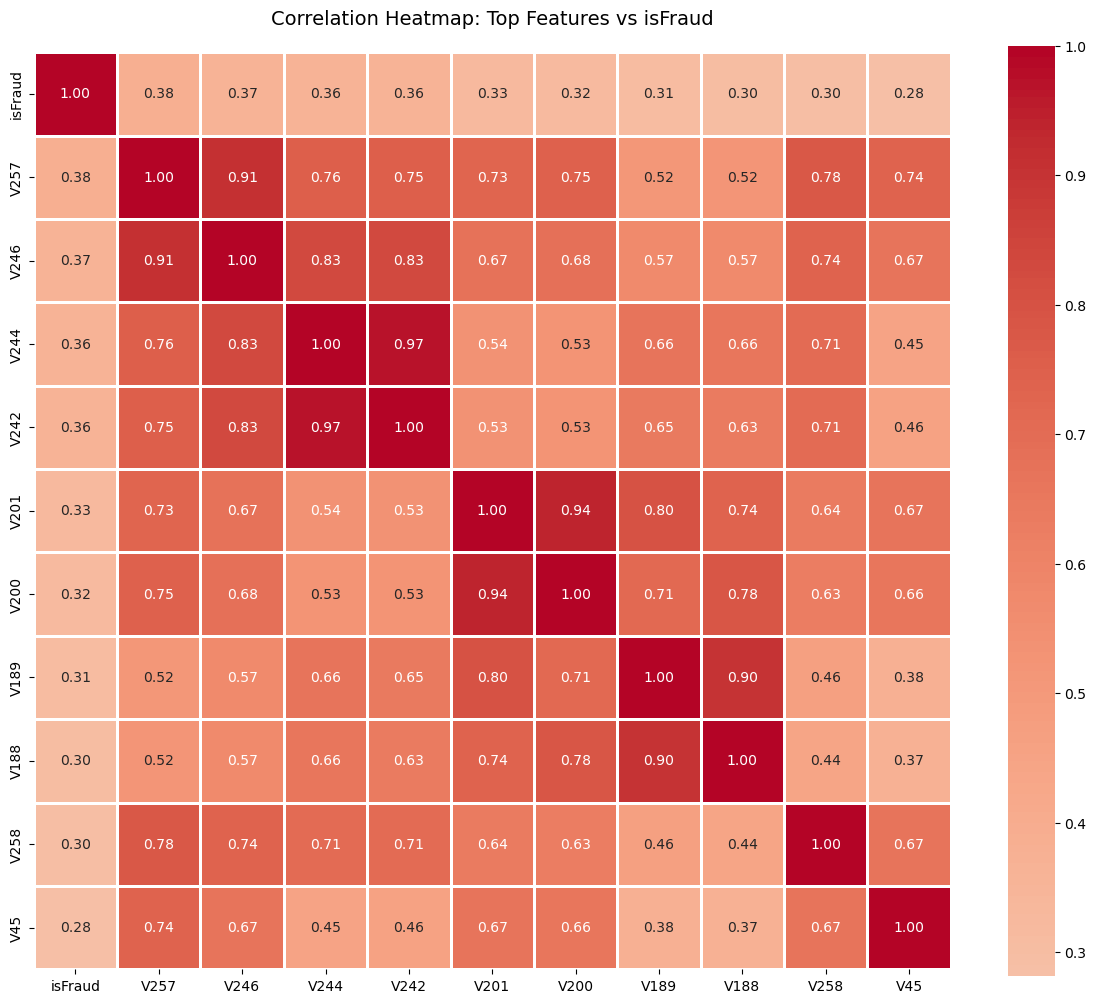

In [27]:
# Correlation heatmap
top_features = top_10_corr.index.tolist()


plt.figure(figsize=(12, 10))
sns.heatmap(trans_train_merged[top_features].corr(), annot=True, fmt='.2f', cmap='coolwarm',
            center=0, square=True, linewidths=1)
plt.title('Correlation Heatmap: Top Features vs isFraud', fontsize=14, pad=20)
plt.tight_layout()
plt.show()

### 3.5 Key Insights from EDA

**Document your findings here:**
- Finding 1:
The standard deviation of transaction amounts is high for both fraudulent and non-fraudulent transactions (≈ 235), which is significantly larger than the mean transaction amount (≈ 130). This indicates high variability in transaction values, making transaction amount alone a weak discriminator for fraud.

- Finding 2:
The “W” product type dominates overall transaction volume, while the “C” product type exhibits a comparable number of fraudulent transactions despite a much smaller total volume. This suggests that “C” transactions are disproportionately higher risk.
A similar risk imbalance is observed across:

    Card type (card6): debit vs. credit

    Device type: mobile vs. desktop

- Finding 3:
The “V” feature set shows strong correlation with the target variable (isFraud). These features are encoded and anonymized to prevent sensitive data leakage, but they capture key behavioural and transactional patterns, making them highly informative for fraud detection models.

---

## 4. Data Preprocessing

### 4.1 Handle Missing Values

In [28]:
#Drop columns with more than 90% missing values
trans_train_transformed = trans_train_merged.copy()
missing_rate_threshold = 0.9
cols_to_drop = missing[missing['missing_percentage'] > missing_rate_threshold]['index'].tolist()
# drop only those columns that exist in the dataframe to avoid KeyError
trans_train_transformed = trans_train_transformed.drop(columns=cols_to_drop)



print("Columns dropped due to high missing rate:")
for col in cols_to_drop:
    print(col)

trans_train_transformed.head()


Columns dropped due to high missing rate:
dist2
D7
id_07
id_08
id_18
id_21
id_22
id_23
id_24
id_25
id_26
id_27


,TransactionID,isFraud,TransactionDT,TransactionAmt,ProductCD,card1,card2,card3,card4,card5,...,id_31,id_32,id_33,id_34,id_35,id_36,id_37,id_38,DeviceType,DeviceInfo
0,2987000,0,86400,68.5,W,13926,NaN,150.0,discover,142.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2987001,0,86401,29.0,W,2755,404.0,150.0,mastercard,102.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2987002,0,86469,59.0,W,4663,490.0,150.0,visa,166.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2987003,0,86499,50.0,W,18132,567.0,150.0,mastercard,117.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2987004,0,86506,50.0,H,4497,514.0,150.0,mastercard,102.0,...,samsung browser 6.2,32.0,2220x1080,match_status:2,T,F,T,T,mobile,SAMSUNG SM-G892A Build/NRD90M


In [29]:
# Fill missing values in ALL numeric columns with the median of their respective columns

numeric_cols = trans_train_transformed.select_dtypes(include=[np.number]).columns
for col in numeric_cols:
    trans_train_transformed[col].fillna(trans_train_transformed[col].median(), inplace=True)

print(trans_train_transformed[numeric_cols].isnull().sum().head(20))

TransactionID     0
isFraud           0
TransactionDT     0
TransactionAmt    0
card1             0
card2             0
card3             0
card5             0
addr1             0
addr2             0
dist1             0
C1                0
C2                0
C3                0
C4                0
C5                0
C6                0
C7                0
C8                0
C9                0
dtype: int64


In [30]:
categorical_df = trans_train_transformed.select_dtypes(include=["object", "category"]) 
    
for i in categorical_df.columns:
    print(f"Number of unique values in Column: {i}")
    print(len(categorical_df[i].unique()))
    print("-" * 50)

Number of unique values in Column: ProductCD
5
--------------------------------------------------
Number of unique values in Column: card4
5
--------------------------------------------------
Number of unique values in Column: card6
5
--------------------------------------------------
Number of unique values in Column: P_emaildomain
60
--------------------------------------------------
Number of unique values in Column: R_emaildomain
61
--------------------------------------------------
Number of unique values in Column: M1
3
--------------------------------------------------
Number of unique values in Column: M2
3
--------------------------------------------------
Number of unique values in Column: M3
3
--------------------------------------------------
Number of unique values in Column: M4
4
--------------------------------------------------
Number of unique values in Column: M5
3
--------------------------------------------------
Number of unique values in Column: M6
3
-------------

In [31]:

# Create imputer for low-cardinality categorical columns
imputer = SimpleImputer(strategy="most_frequent")

# Count unique values per column
unique_counts = categorical_df.nunique()

# Split into low vs high cardinality
low_cardinality = unique_counts[unique_counts < 100].index.tolist()
high_cardinality = unique_counts[unique_counts >= 100].index.tolist()

# --- Handle low-cardinality columns with most frequent imputation ---
trans_train_transformed[low_cardinality] = imputer.fit_transform(trans_train_transformed[low_cardinality])


# --- Handle high-cardinality columns by filling with "Missing" ---
trans_train_transformed[high_cardinality] = trans_train_transformed[high_cardinality].fillna("Missing")


### 4.2 Handle Outliers

In [32]:
# Identify and handle outliers if necessary
# Use IQR method, z-score, or domain knowledge

#Define transaction amount outliers using IQR method

Q1 = total_amt.quantile(0.25)
Q3 = total_amt.quantile(0.75)
IQR = Q3 - Q1

outliers = total_amt[(total_amt < (Q1 - 1.5 * IQR)) | (total_amt > (Q3 + 1.5 * IQR))]

print(total_amt.sort_values(ascending=False).head(10))
print("="*90)
print(total_amt.sort_values(ascending=True).head(10))


274336    31936.0
274339    31936.0
296021     6452.0
248413     6084.0
384603     5544.0
275529     5420.0
275535     5420.0
584767     5368.0
315172     5280.0
462514     5280.0
Name: TransactionAmt, dtype: float64
374299    0.250977
367961    0.271973
205370    0.291992
205865    0.291992
205872    0.291992
29976     0.291992
205382    0.291992
205393    0.350098
492354    0.364014
42265     0.424072
Name: TransactionAmt, dtype: float64


### 4.3 Feature Engineering

In [33]:
# Create new features if beneficial
# Examples:
# - Combine existing features
# - Extract date components (year, month, day)
# - Create ratios or differences
# - Bin continuous variables

### 4.4 Encode Categorical Variables

In [34]:
# Encode categorical variables


trans_train_transformed = pd.get_dummies(trans_train_transformed,columns=low_cardinality, drop_first=True)

                       
encoder = TargetEncoder()

# Fit on training data (with target) and transform training set
trans_train_transformed[high_cardinality] = encoder.fit_transform(
    trans_train_transformed[high_cardinality], trans_train_transformed["isFraud"]
)


In [35]:
trans_train_transformed.head(20)

,TransactionID,isFraud,TransactionDT,TransactionAmt,card1,card2,card3,card5,addr1,addr2,...,id_30_iOS 9.3.5,id_30_other,id_34_match_status:0,id_34_match_status:1,id_34_match_status:2,id_35_T,id_36_T,id_37_T,id_38_T,DeviceType_mobile
0,2987000,0,86400,68.5000,13926,361.0,150.0,142.0,315.0,87.0,...,False,False,False,False,True,True,False,True,False,False
1,2987001,0,86401,29.0000,2755,404.0,150.0,102.0,325.0,87.0,...,False,False,False,False,True,True,False,True,False,False
2,2987002,0,86469,59.0000,4663,490.0,150.0,166.0,330.0,87.0,...,False,False,False,False,True,True,False,True,False,False
3,2987003,0,86499,50.0000,18132,567.0,150.0,117.0,476.0,87.0,...,False,False,False,False,True,True,False,True,False,False
4,2987004,0,86506,50.0000,4497,514.0,150.0,102.0,420.0,87.0,...,False,False,False,False,True,True,False,True,True,True
5,2987005,0,86510,49.0000,5937,555.0,150.0,226.0,272.0,87.0,...,False,False,False,False,True,True,False,True,False,False
6,2987006,0,86522,159.0000,12308,360.0,150.0,166.0,126.0,87.0,...,False,False,False,False,True,True,False,True,False,False
7,2987007,0,86529,422.5000,12695,490.0,150.0,226.0,325.0,87.0,...,False,False,False,False,True,True,False,True,False,False
8,2987008,0,86535,15.0000,2803,100.0,150.0,226.0,337.0,87.0,...,False,False,False,True,False,True,False,False,True,True
9,2987009,0,86536,117.0000,17399,111.0,150.0,224.0,204.0,87.0,...,False,False,False,False,True,True,False,True,False,False


### 4.5 Prepare Features and Target

In [36]:
# Split data with stratification due to laptop memory constraints
print("✂️ Splitting data with stratification...\n")

X = trans_train_transformed.drop(columns=['isFraud'])
y = trans_train_transformed['isFraud']

# First split: only keep 50% for training model due to laptop memory constraints
X_model, X_drop, y_model, y_drop = train_test_split(
    X, y, test_size=0.5, random_state=42, stratify=y
)



print(f"✅ Data split complete with stratification!")
print(f"\n📊 Drop set:   {X_drop.shape[0]:>6,} samples ({X_drop.shape[0]/len(X)*100:.1f}%)")


✂️ Splitting data with stratification...

✅ Data split complete with stratification!

📊 Drop set:   295,270 samples (50.0%)


In [37]:
print(y_model.value_counts(normalize = True))
print(y_model.value_counts())


isFraud
0    0.965008
1    0.034992
Name: proportion, dtype: float64
isFraud
0    284938
1     10332
Name: count, dtype: int64


In [38]:
# 🔄 Handle class imbalance by adding more positive samples
new_true_rate = 0.1
current_true = y_model.sum()
desired_true = len(y_model) * new_true_rate
total_true_add = round((desired_true - current_true) / (1 - new_true_rate), 0)

print(f" Additional true samples needed: {total_true_add}")

 Additional true samples needed: 21328.0


In [39]:
# Combine dropped set with positives to rebalance
drop_set = pd.concat([X_drop, y_drop.rename("isFraud")], axis=1)
true_target = drop_set[drop_set["isFraud"] == 1]

model_set = pd.concat([X_model, y_model.rename("isFraud")], axis=1)
new_model_set = pd.concat([model_set, true_target], axis=0)

# Final balanced dataset
X_model = new_model_set.drop(columns=['isFraud'])
y_model = new_model_set['isFraud']

print("\n📊 Class distribution after balancing:")
print(new_model_set["isFraud"].value_counts(normalize=True))


📊 Class distribution after balancing:
isFraud
0    0.932386
1    0.067614
Name: proportion, dtype: float64


In [40]:
# ⚖️ Second split: 80% train+val, 20% test
X_temp, X_test, y_temp, y_test = train_test_split(
    X_model, y_model, test_size=0.2, random_state=42, stratify=y_model
)

# ⚖️ Third split: 75% train, 25% val (from temp)
X_train, X_val, y_train, y_val = train_test_split(
    X_temp, y_temp, test_size=0.25, random_state=42, stratify=y_temp
)

# ✅ Final summary
print("\n✅ Data split complete with stratification!")
print(f"📊 Training set:   {X_train.shape[0]:,} samples ({X_train.shape[0]/len(X)*100:.1f}%)")
print(f"📊 Validation set: {X_val.shape[0]:,} samples ({X_val.shape[0]/len(X)*100:.1f}%)")
print(f"📊 Test set:       {X_test.shape[0]:,} samples ({X_test.shape[0]/len(X)*100:.1f}%)")

# Verify stratification
print("\n✅ Class distribution maintained:")
for name, y_split in zip(["Train", "Validation", "Test"], [y_train, y_val, y_test]):
    print(f"   {name}: {y_split.value_counts(normalize=True)[1]:.3f} positive class")

print("\n🔒 Test set is now LOCKED until final evaluation!")


✅ Data split complete with stratification!
📊 Training set:   183,360 samples (31.0%)
📊 Validation set: 61,120 samples (10.3%)
📊 Test set:       61,121 samples (10.4%)

✅ Class distribution maintained:
   Train: 0.068 positive class
   Validation: 0.068 positive class
   Test: 0.068 positive class

🔒 Test set is now LOCKED until final evaluation!


In [41]:
# Verify shapes
# X.shape, y.shape

print(f"Feature matrix shape: {X_train.shape}")
print(f"Target vector shape: {y_train.shape}")

Feature matrix shape: (183360, 620)
Target vector shape: (183360,)


---
## 6. Modeling

### 6.1 Baseline Model

In [42]:
# Start with a simple baseline model
# Example for classification:
baseline_pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ("pca", PCA(n_components=0.95)),
     ('model', LogisticRegression(random_state=42))
 ])

In [43]:
# Train baseline
baseline_pipeline.fit(X_train, y_train)

,steps,"[('scaler', ...), ('pca', ...), ...]"
,transform_input,None
,memory,None
,verbose,False
,copy,True
,with_mean,True
,with_std,True
,n_components,0.95
,copy,True
,whiten,False
,svd_solver,'auto'


In [44]:
# Evaluate baseline
y_pred_baseline = baseline_pipeline.predict(X_val)
baseline_score = accuracy_score(y_val, y_pred_baseline)
f"Accuracy: {baseline_score:.1%}"

'Accuracy: 95.0%'

### 6.2 Model 2: SVM

In [45]:
svm = Pipeline([
     ('scaler', StandardScaler()),
    ("pca", PCA(n_components=2)),
     ('model', SVC(kernel='rbf', random_state=42))
])

In [46]:
svm.fit(X_train, y_train)

,steps,"[('scaler', ...), ('pca', ...), ...]"
,transform_input,None
,memory,None
,verbose,False
,copy,True
,with_mean,True
,with_std,True
,n_components,2
,copy,True
,whiten,False
,svd_solver,'auto'


In [47]:
# Evaluate
y_pred_svm = svm.predict(X_val)
score_svm = accuracy_score(y_val, y_pred_svm)
f"Accuracy: {score_svm:.1%}"

'Accuracy: 93.5%'

### 6.3 Model 3: XG Boost

In [48]:
# Try a third model
# Continue pattern from above



xg = XGBClassifier(

        eval_metric="auc",
        random_state=42
    )


# Fit pipeline
xg.fit(X_train, y_train)




,objective,'binary:logistic'
,base_score,None
,booster,None
,callbacks,None
,colsample_bylevel,None
,colsample_bynode,None
,colsample_bytree,None
,device,None
,early_stopping_rounds,None
,enable_categorical,False
,eval_metric,'auc'


In [49]:
# Evaluate
y_pred_xg = xg.predict(X_val)
xg_score = accuracy_score(y_val, y_pred_xg)
f"Accuracy: {xg_score:.1%}"

'Accuracy: 96.6%'

### 6.4 Compare Models

In [50]:
# Create comparison DataFrame



results = pd.DataFrame({
    'Model': ['Baseline', 'SVM', 'XGBoost'],
    'Accuracy': [baseline_score, score_svm, xg_score],
    'Precision': [precision_score(y_val, y_pred_baseline),
                  precision_score(y_val, y_pred_svm),
                  precision_score(y_val, y_pred_xg)],
    'Recall': [recall_score(y_val, y_pred_baseline),
               recall_score(y_val, y_pred_svm),
               recall_score(y_val, y_pred_xg)],
    'F1-Score': [f1_score(y_val, y_pred_baseline),
                 f1_score(y_val, y_pred_svm),
                 f1_score(y_val, y_pred_xg)]
})
# results

print("\n" + "="*90)
print("Model Performance Comparison on Validation Set")
print("="*90)       
print(results.to_string(index=False))


Model Performance Comparison on Validation Set
   Model  Accuracy  Precision   Recall  F1-Score
Baseline  0.949542   0.831333 0.318413  0.460462
     SVM  0.935259   0.694690 0.075974  0.136968
 XGBoost  0.965952   0.905534 0.554319  0.687678


In [51]:
# Visualize comparison
fig = px.bar(results, x='Model', y='Recall', 
             title='Model Performance Comparison')
fig.show()

## Conclusion

Although all models achieved strong accuracy scores, their recall and F1 scores were notably low—particularly for the SVM model, which may have been affected by an insufficient number of PCA components. In this case study, recall is the most critical metric, since failing to detect fraudulent transactions carries a higher cost than false positives. Therefore, XGBoost was selected for hyperparameter tuning, as it offers the best potential to improve recall while maintaining overall performance.

---
## 7. Hyperparameter Tuning

### 7.1 Select Best Model for Tuning

In [52]:
best_model = XGBClassifier(
    objective="binary:logistic",
    eval_metric="aucpr",         
    tree_method="hist",
    learning_rate=0.05,           
    n_estimators=2000,            
    random_state=42
)

### 7.2 Define Parameter Grid

In [53]:
param_dist = {
    "max_depth": [4, 5, 6, 7, 8],
    "min_child_weight": [1, 2, 3, 5],
    "gamma": [0, 0.1, 0.3, 0.5],
    "subsample": [0.7, 0.8, 0.9],
    "colsample_bytree": [0.7, 0.8, 0.9],
    "reg_alpha": [0, 0.1, 0.5, 1],
    "reg_lambda": [1, 2, 3],
    "xscale_pos_weight": [12, 16, 20,23]  # 94/6 ≈ 15.7
}

### 7.3 Randomized Search

In [54]:
random_search = RandomizedSearchCV(
    estimator=best_model,
    param_distributions=param_dist,
    n_iter=40,
    scoring="f1",               
    cv=3,
    n_jobs=-1,
    verbose=1,
    random_state=42
)




In [55]:
random_search.fit(X_train, y_train)


print("Best params:")
print(random_search.best_params_)

Fitting 3 folds for each of 40 candidates, totalling 120 fits
Best params:
{'xscale_pos_weight': 16, 'subsample': 0.9, 'reg_lambda': 2, 'reg_alpha': 1, 'min_child_weight': 1, 'max_depth': 8, 'gamma': 0, 'colsample_bytree': 0.7}


In [56]:
y_pred_val = random_search.predict(X_val)
print("Recall score of tuned model:",recall_score(y_val, y_pred_val) )
print("F1 score of tuned model:", random_search.best_score_)

Recall score of tuned model: 0.682071134768933
F1 score of tuned model: 0.756934524177145


**Traning Model:**  

 After performing hyperparameter tuning, the XGBoost model showed an improvement in recall score compared to the baseline. However, the recall did not reach the expected benchmark of 80%, which is considered desirable for a robust fraud detection system.

### 7.4 Final Model

In [57]:
# Get best model
final_model = random_search.best_estimator_

---
## 8. Final Evaluation

### 8.1 Test Set Performance

In [58]:
# Predict on test set
y_pred_final = final_model.predict(X_test)

In [59]:
# Calculate metrics

final_accuracy = accuracy_score(y_test, y_pred_final)
final_precision = precision_score(y_test, y_pred_final)
final_recall = recall_score(y_test, y_pred_final)
final_f1 = f1_score(y_test, y_pred_final)


In [60]:
# Display metrics
print(f"Final Model Performance:")
print(f"Accuracy: {final_accuracy:.1%}")
print(f"Precision: {final_precision:.1%}")
print(f"Recall: {final_recall:.1%}")
print(f"F1-Score: {final_f1:.1%}")

Final Model Performance:
Accuracy: 97.5%
Precision: 94.4%
Recall: 66.9%
F1-Score: 78.3%


### 8.2 Classification Report

In [61]:
# Detailed classification report
print(classification_report(y_test, y_pred_final))

              precision    recall  f1-score   support

           0       0.98      1.00      0.99     56988
           1       0.94      0.67      0.78      4133

    accuracy                           0.97     61121
   macro avg       0.96      0.83      0.89     61121
weighted avg       0.97      0.97      0.97     61121



### 8.3 Confusion Matrix

In [62]:
# For classification problems
cm = confusion_matrix(y_test, y_pred_final)
fig = px.imshow(cm, 
                 text_auto=True,
                 title='Confusion Matrix',
                 labels=dict(x='Predicted', y='Actual'))
fig.show()

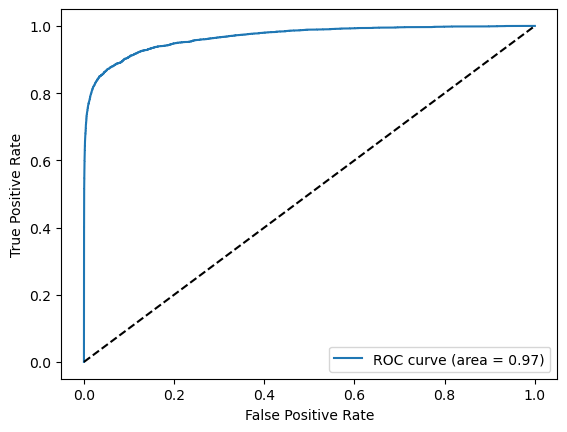

In [ ]:
#ROC-AUC Curve
y_probs = final_model.predict_proba(X_test)[:,1]
fpr,tpr, thresholds = roc_curve(y_test,y_probs)
roc_auc = auc(fpr,tpr)

plt.plot(fpr,tpr,label = f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0,1], [0,1],'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc = "lower right")
plt.show()

### 8.4 Feature Importance

In [63]:
# If your model supports feature importance
importances = final_model.feature_importances_
feature_importance = pd.DataFrame({
     'Feature': X.columns,
     'Importance': importances
 }).sort_values('Importance', ascending=False)

plt.figure(figsize=(8, 4))
fig = px.bar(feature_importance.head(20), 
              x='Importance', y='Feature',
              title='Top 20 Most Important Features',
              orientation='h',
              width=1600, 
              height=800 )
fig.show()



<Figure size 800x400 with 0 Axes>

In [64]:
top_20 = feature_importance.head(20)
trans_train_transformed[top_20["Feature"].to_list()].head(20)

,V258,V201,V91,V295,V294,V70,V156,V187,V325,C8,id_35_T,V326,V247,V189,id_30_Windows 8.1,C14,V149,V327,V172,V323
0,1.0,1.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,True,0.0,1.0,1.0,False,1.0,1.0,0.0,0.0,0.0
1,1.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,True,0.0,1.0,1.0,False,1.0,1.0,0.0,0.0,0.0
2,1.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,True,0.0,1.0,1.0,False,1.0,1.0,0.0,0.0,0.0
3,1.0,1.0,0.0,24.0,38.0,0.0,1.0,1.0,0.0,0.0,True,0.0,1.0,1.0,False,1.0,1.0,0.0,0.0,0.0
4,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,True,0.0,1.0,1.0,False,1.0,0.0,0.0,0.0,0.0
5,1.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,True,0.0,1.0,1.0,False,1.0,1.0,0.0,0.0,0.0
6,1.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,True,0.0,1.0,1.0,False,1.0,1.0,0.0,0.0,0.0
7,1.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,True,0.0,1.0,1.0,False,1.0,1.0,0.0,0.0,0.0
8,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,True,0.0,1.0,1.0,False,1.0,0.0,0.0,0.0,0.0
9,1.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,True,0.0,1.0,1.0,False,2.0,1.0,0.0,0.0,0.0


---
## 9. Business Insights & Recommendations

### 9.1 Key Findings

**Finding 1:** Importance of “V” Fields
- The “V” feature set demonstrates the highest correlation and importance in predicting fraud status.

- These engineered variables capture subtle behavioral and transactional patterns that strongly differentiate fraudulent from legitimate activity.

**Finding 2:** Transaction Amount Variability
- The standard deviation of transaction amounts (≈ 235) is significantly larger than the mean (≈ 130) for both fraudulent and non-fraudulent transactions.

- This high variability suggests that transaction amount alone is not a reliable discriminator for fraud detection, as both legitimate and fraudulent transactions can exhibit wide ranges.

**Finding 3:**
- The “W” product type dominates overall transaction volume, but the “C” product type shows a disproportionately high fraud rate despite its smaller share.

- Similar imbalances are observed across other dimensions:

     Card Type (card6): Debit vs. credit cards show differing fraud risk profiles.

     Device Type: Mobile transactions exhibit higher fraud risk compared to desktop transactions.


### 9.2 Business Recommendations

1. **Recommendation 1:** Leverage “V” Fields in Fraud Detection Models

- Prioritize the “V” feature set during model training and monitoring, as these variables provide strong predictive signals.

   
2. **Recommendation 2:** Deploy Automated Fraud Alerts

- Implement a real-time notification system that flags suspicious transactions based on model predictions.

- Alerts should be tiered (e.g., high-risk vs. medium-risk) to balance fraud prevention with customer experience.


   

### 9.3 Model Limitations

** Performance Constraints:** Recall and F1 scores remain limited due to several factors:

- Class Imbalance: Fraudulent transactions represent only ~3% of the dataset, making detection challenging.

- Computational Limitations: Hardware restrictions required reducing dataset size and narrowing hyperparameter search ranges.

- Data Visibility: Many fields are anonymized or encoded, limiting interpretability and feature engineering opportunities.


### 9.4 Future Improvements

- **Improvement 1:** Upgrade computational resources (GPU/CPU) to enable full dataset training and broader hyperparameter optimization.
- **Improvement 2:** Address class imbalance by augmenting fraudulent cases (e.g., synthetic oversampling, anomaly detection techniques) to achieve a more balanced dataset.
- **Improvement 3:** Seek access to more transparent or less-encoded data fields, with appropriate permissions, to enhance feature engineering and interpretability.

---

## 10. Save Model

In [65]:
# Save final model
joblib.dump(final_model, 'final_model.pkl')

['final_model.pkl']

In [66]:
# Save model metadata
import json
metadata = {
    'model_type': 'XGClassifier',
    'accuracy': float(final_accuracy),
    'precision': float(final_precision),
    'recall': float(final_recall),
    'f1': float(final_f1),
    'features': X.columns.tolist(),
    'training_date': '2026-01-19',
    'best_params': final_model.get_params()
}

with open('model_metadata.json', 'w') as f:
    json.dump(metadata, f, indent=2)

---
## 11. Conclusion

### Summary

**Problem:**  Fraudulent banking transactions

**Solution:**  A machine learning–based fraud detection model was developed to predict potentially fraudulent transactions and trigger alerts for stakeholders.

**Results:** Model performance was evaluated using Recall and F1 score, achieving 67% recall and 78% F1 score. The ROC–AUC of 97% indicates ability to distinguish fraudulent from non-fraudulent transactions, even with highly imbalanced data. While these results show meaningful progress, further optimization is needed to reach industry benchmarks.

**Impact:** reduce fraudulent transactions, prevent financial losses, and strengthen customer confidence in digital banking systems.

### Next Steps

1. Stakeholder Presentation: Share findings with stakeholders to secure investment in upgraded computational resources and expanded datasets.

2. Model Deployment: Integrate the fraud detection model into the bank’s application with real-time notification systems for suspicious activity.

3. Performance Monitoring: Establish weekly reviews of recall and F1 scores to track improvements, identify weaknesses, and refine the model continuously.

---

**Thank you!**

---

**AI Tech Institute** | *Building Tomorrow's AI Engineers Today*